# 5. Analysis of Exchange Pattern

In [2]:
import pandas as pd
import pickle
import numpy as np
# Plot the relationship between genres
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from func import get_relationship, relationship_with_name, plot_relationship, plot_relationship_with_t
import scipy.stats

In [ ]:
with open('./data/genres_igdb.pkl', 'rb') as f:
    genres_igdb = pickle.load(f)

## 1. Load the Reddit Data
paris_dense is the confirmed transaction data with time from Rappaz et. al (2017).

In [3]:
pair_time = pd.read_csv('./data/pairs_dense.csv',names=['user1','game1','user2','game2','time'])
pair_time['time'] = pd.to_datetime(pair_time['time'],unit='s')
pair_time = pair_time.loc[pair_time['time']>='2000-01-01']

In [57]:
# Load the gameswap transaction data with col names ['user1','game1','user2','game2']
pair = pd.read_csv('./data/pairs.csv', names=['user1','game1','user2','game2'])
# Load have and wish data
have = pd.read_csv('./data/have.csv', names=['user','game'])
wish = pd.read_csv('./data/wish_dense.csv', names=['user','game'])
# Load the games data we get from IGDB
games = pd.read_csv('./data/games_tbp.csv', index_col=0)
# Add a column of index with name 'game_id', second column
games.insert(1, 'game_id', range(0, len(games)))
games_genres = games[['game_id', 'genres']]

In [5]:
# Outer join have and wish on user
have_wish = have.merge(wish, on='user', how='outer', suffixes=['1','2']).astype('Int64')
print(have_wish.shape)

(332258, 3)


In [6]:
have_wish_cleaned = have_wish.dropna()
have_wish_relationship = get_relationship(have_wish_cleaned, games_genres, have_wish=True)
confirmed_relationship = get_relationship(pair, games_genres)

In [27]:
have_genres = have.join(games_genres.set_index('game_id'), on='game')
have_genres = have_genres.dropna()
have_genres['genres'] = have_genres['genres'].apply(lambda x: [int(y) for y in x[1:-1].split(',')])
have_genres_dict = {}
for genres_list in have_genres['genres']:
    try:
        for genres in genres_list:
            # calculate the total number of each genre.
            have_genres_dict[genres] = have_genres_dict.get(genres, 0)+1
    except:
        pass
df_have_genres = pd.DataFrame.from_dict(have_genres_dict, orient='index', columns=['count'])
df_have_genres.reset_index(inplace=True)
df_have_genres.columns = ['genres', 'count']
df_have_genres['percent'] = df_have_genres['count']/df_have_genres['count'].sum()
df_have = df_have_genres.merge(genres_igdb[['id','name']], left_on='genres', right_on='id').sort_values(by='name', ascending=True)

In [123]:
wish_genres = wish.join(games_genres.set_index('game_id'), on='game')
wish_genres = wish_genres.dropna()
wish_genres['genres'] = wish_genres['genres'].apply(lambda x: [int(y) for y in x[1:-1].split(',')])
wish_genres_dict = {}
for genres_list in wish_genres['genres']:
    try:
        for genres in genres_list:
            # calculate the total number of each genre.
            wish_genres_dict[genres] = wish_genres_dict.get(genres, 0)+1
    except:
        pass
df_wish_genres = pd.DataFrame.from_dict(wish_genres_dict, orient='index', columns=['count'])
df_wish_genres.reset_index(inplace=True)
df_wish_genres.columns = ['genres', 'count']
df_wish_genres['percent'] = df_wish_genres['count']/df_wish_genres['count'].sum()
df_wish = df_wish_genres.merge(genres_igdb[['id','name']], left_on='genres', right_on='id').sort_values(by='name', ascending=True)

## 2. Plot the relationship
The detailed information about the games is obtained using IGDB.


In [60]:
with open('data/genres_igdb.pkl','rb') as f:
    genres_names = pickle.load(f)[['id','name']]
df_console_genres_count = pd.read_pickle('./data/genres_count_total.pkl')

In [61]:
df_console_genres_count.shape

(23, 6)

In [62]:
confirmed = relationship_with_name(confirmed_relationship, genres_names, have_wish=False)

/home/jliu/project/func.py:92: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')


In [63]:
confirmed.apply(lambda x: sum(x), axis=1).sort_values(ascending=False)

name_1
Adventure                     3744.0
Role-playing (RPG)            2777.0
Shooter                       1694.0
Platform                      1459.0
Strategy                       613.0
Puzzle                         536.0
Turn-based strategy (TBS)      500.0
Hack and slash/Beat 'em up     463.0
Fighting                       391.0
Racing                         381.0
Simulator                      370.0
Tactical                       296.0
Sport                          281.0
Arcade                         205.0
Visual Novel                    96.0
Real Time Strategy (RTS)        85.0
Point-and-click                 73.0
Indie                           67.0
Card & Board Game               63.0
Music                           36.0
Pinball                          7.0
Quiz/Trivia                      6.0
dtype: float64

In [64]:
# Choose the genres that have more than 100 transactions.
confirmed_filtered = confirmed.loc[confirmed.apply(lambda x: x.sum(), axis=1).sort_values(ascending=False)>=100,confirmed.apply(lambda x: x.sum(), axis=1).sort_values(ascending=False)>=100]

In [65]:
genres_filtered = genres_names[genres_names['name'].isin(confirmed_filtered.index)]

In [66]:
df_console_genres_count = df_console_genres_count.loc[df_console_genres_count['name_total'].isin(confirmed_filtered.index)][['name_console','count_console']]
df_console_genres_count['percent'] = df_console_genres_count['count_console']/df_console_genres_count['count_console'].sum()*100

In [67]:
relationship_confirmed = relationship_with_name(confirmed_relationship, genres_names=genres_filtered, have_wish=False)
relationship_have_wish = relationship_with_name(have_wish_relationship, genres_names=genres_filtered, have_wish=True)

genres_confirmed = relationship_confirmed.columns
genres_have_wish = relationship_have_wish.columns

# Expand the relationship_confirmed and relationship_have_wish to the same size
relationship_confirmed = relationship_confirmed.reindex(index=relationship_have_wish.index, columns=relationship_have_wish.columns, fill_value=0)

# Normalize the relationship_confirmed and relationship_have_wish, they are symmetric
relationship_confirmed_norm = relationship_confirmed.apply(lambda x: x/x.sum() if x.sum()!=0 else 0, axis=1)*100
# for i in range(relationship_confirmed_norm.shape[0]):
#     relationship_confirmed_norm.iloc[i,:] = relationship_confirmed_norm.iloc[:,i] 
relationship_confirmed_norm.fillna(0, inplace=True)

relationship_have_wish_norm = relationship_have_wish.apply(lambda x: x/x.sum() if x.sum()!=0 else 0, axis=1)*100
# for i in range(relationship_have_wish_norm.shape[0]):
#     relationship_have_wish_norm.iloc[i,:] = relationship_have_wish_norm.iloc[:,i]
relationship_have_wish_norm.fillna(0, inplace=True)

# Calculate the difference between relationship_confirmed and relationship_have_wish
relationship_diff = relationship_have_wish_norm - relationship_confirmed_norm

# Transform the dataframe to be better for plotting.
relationship_diff_plot = relationship_diff.copy()
relationship_diff_plot = relationship_diff_plot
relationship_diff_plot = relationship_diff_plot.round(2)

/home/jliu/project/func.py:92: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')
/home/jliu/project/func.py:92: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')


In [109]:
relationship_confirmed

name_2,Adventure,Arcade,Fighting,Hack and slash/Beat 'em up,Platform,Puzzle,Racing,Role-playing (RPG),Shooter,Simulator,Sport,Strategy,Tactical,Turn-based strategy (TBS)
name_1,,,,,,,,,,,,,,
Adventure,627.0,58.0,106.0,144.0,415.0,146.0,115.0,886.0,535.0,103.0,79.0,183.0,97.0,143.0
Arcade,58.0,2.0,10.0,7.0,31.0,8.0,6.0,35.0,22.0,4.0,5.0,4.0,0.0,7.0
Fighting,106.0,10.0,8.0,7.0,45.0,15.0,15.0,78.0,35.0,9.0,12.0,15.0,7.0,9.0
Hack and slash/Beat 'em up,144.0,7.0,7.0,7.0,34.0,15.0,16.0,97.0,61.0,10.0,8.0,20.0,11.0,14.0
Platform,415.0,31.0,45.0,34.0,100.0,73.0,57.0,277.0,152.0,40.0,37.0,65.0,22.0,49.0
Puzzle,146.0,8.0,15.0,15.0,73.0,10.0,14.0,98.0,64.0,15.0,8.0,23.0,11.0,20.0
Racing,115.0,6.0,15.0,16.0,57.0,14.0,5.0,56.0,51.0,7.0,9.0,13.0,1.0,10.0
Role-playing (RPG),886.0,35.0,78.0,97.0,277.0,98.0,56.0,382.0,331.0,83.0,39.0,137.0,68.0,123.0
Shooter,535.0,22.0,35.0,61.0,152.0,64.0,51.0,331.0,168.0,43.0,47.0,75.0,35.0,39.0


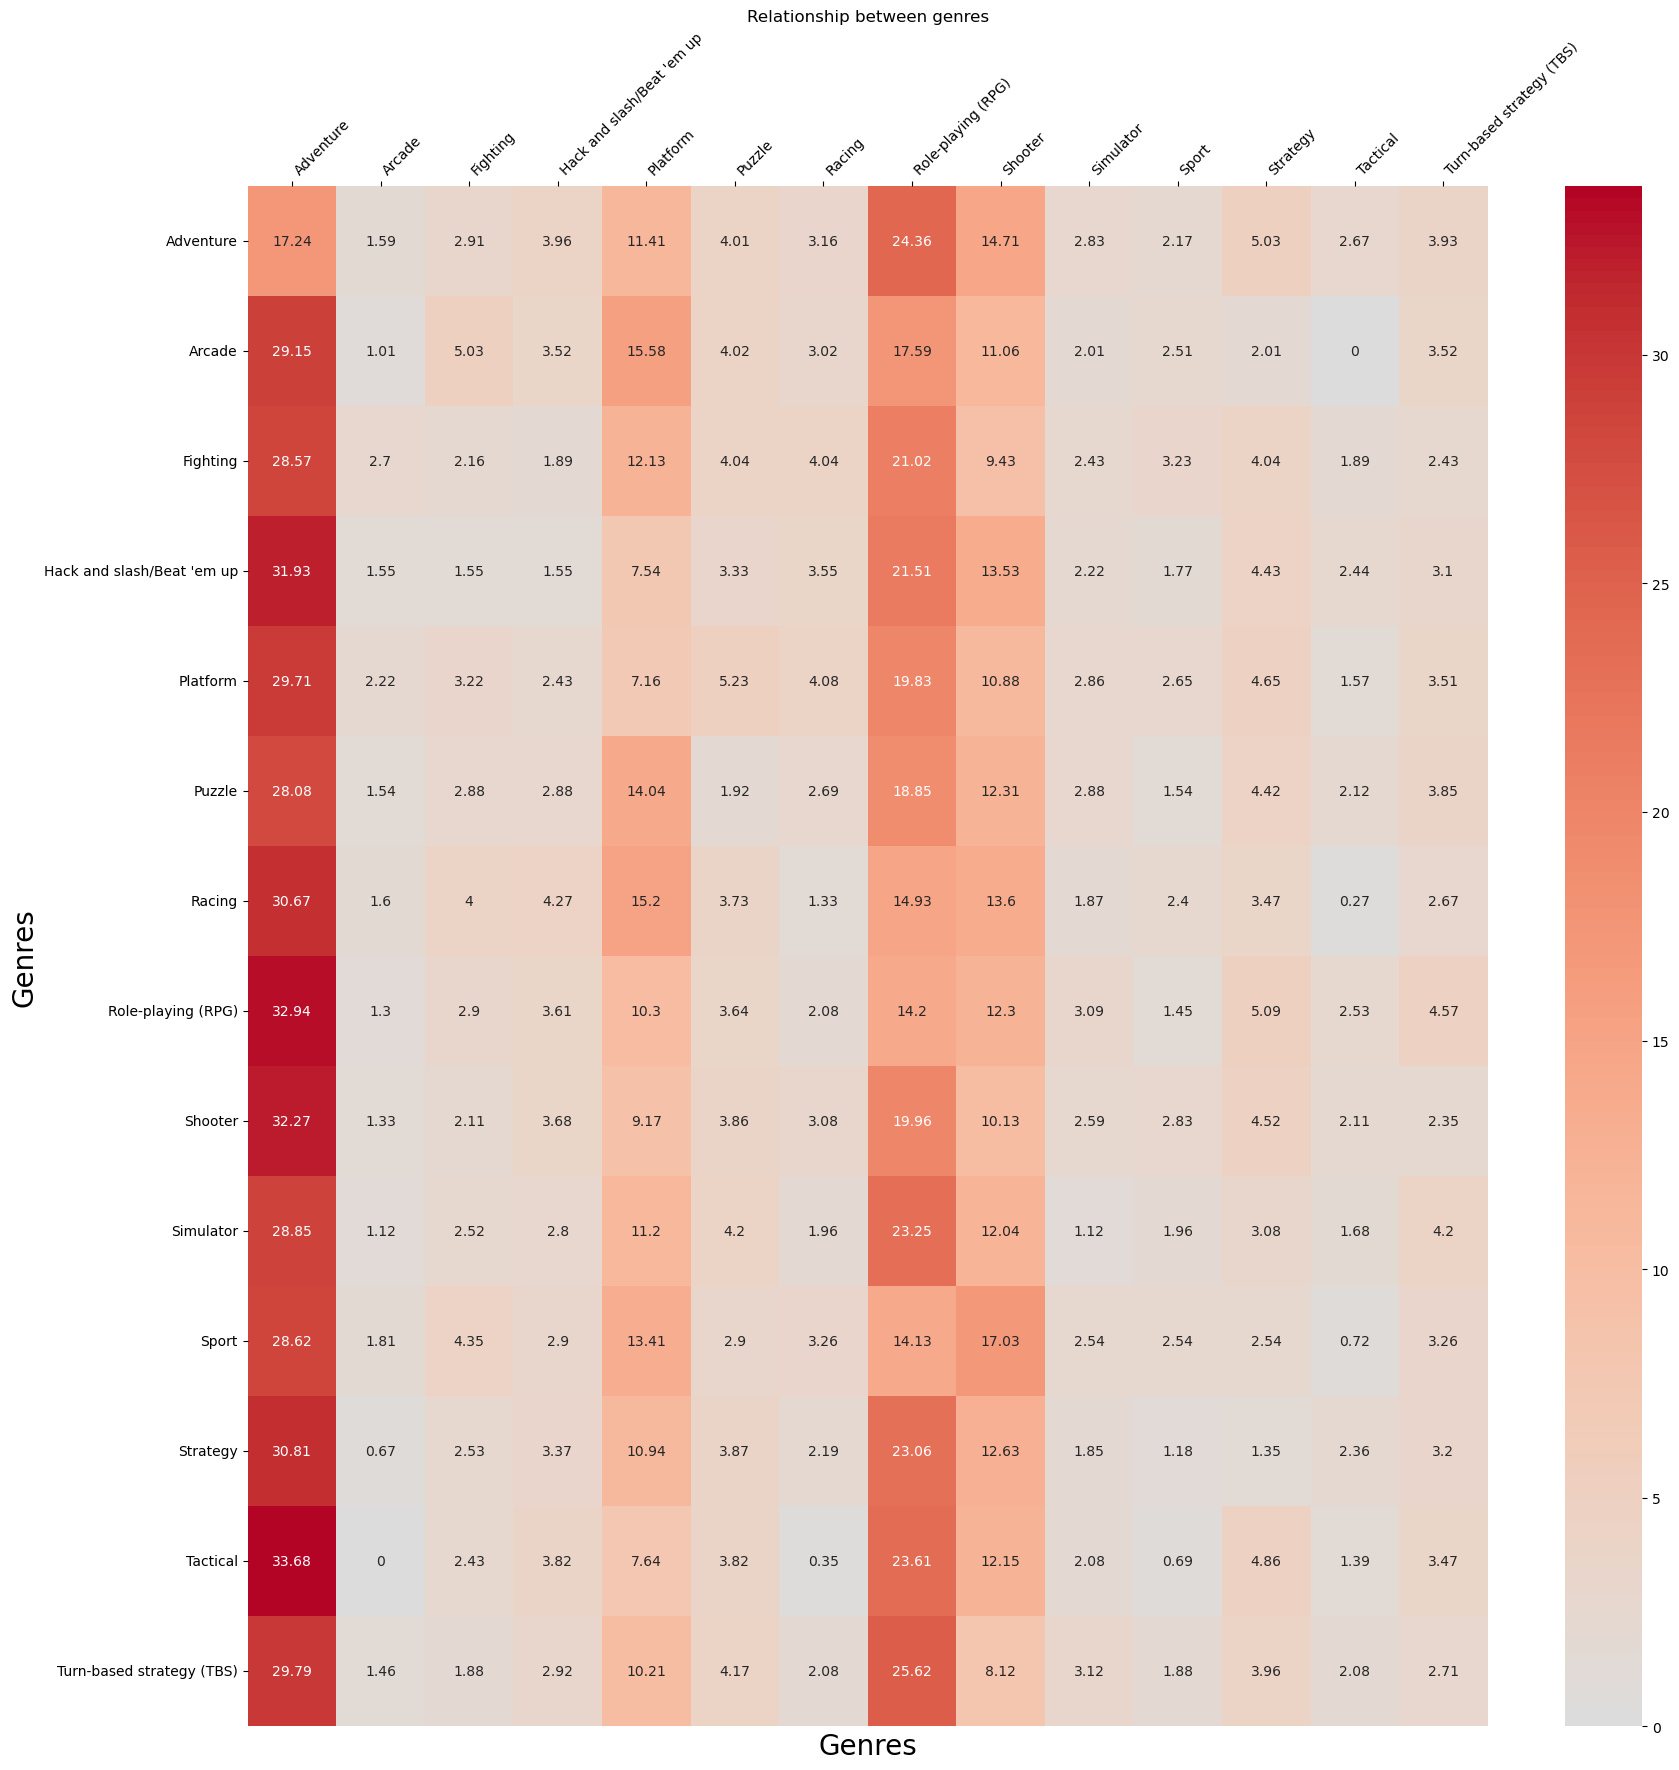

In [68]:
plot_relationship((relationship_confirmed_norm).round(2), 'confirmed_norm_filtered', genres_names=genres_names, have_wish=False,processed=True)

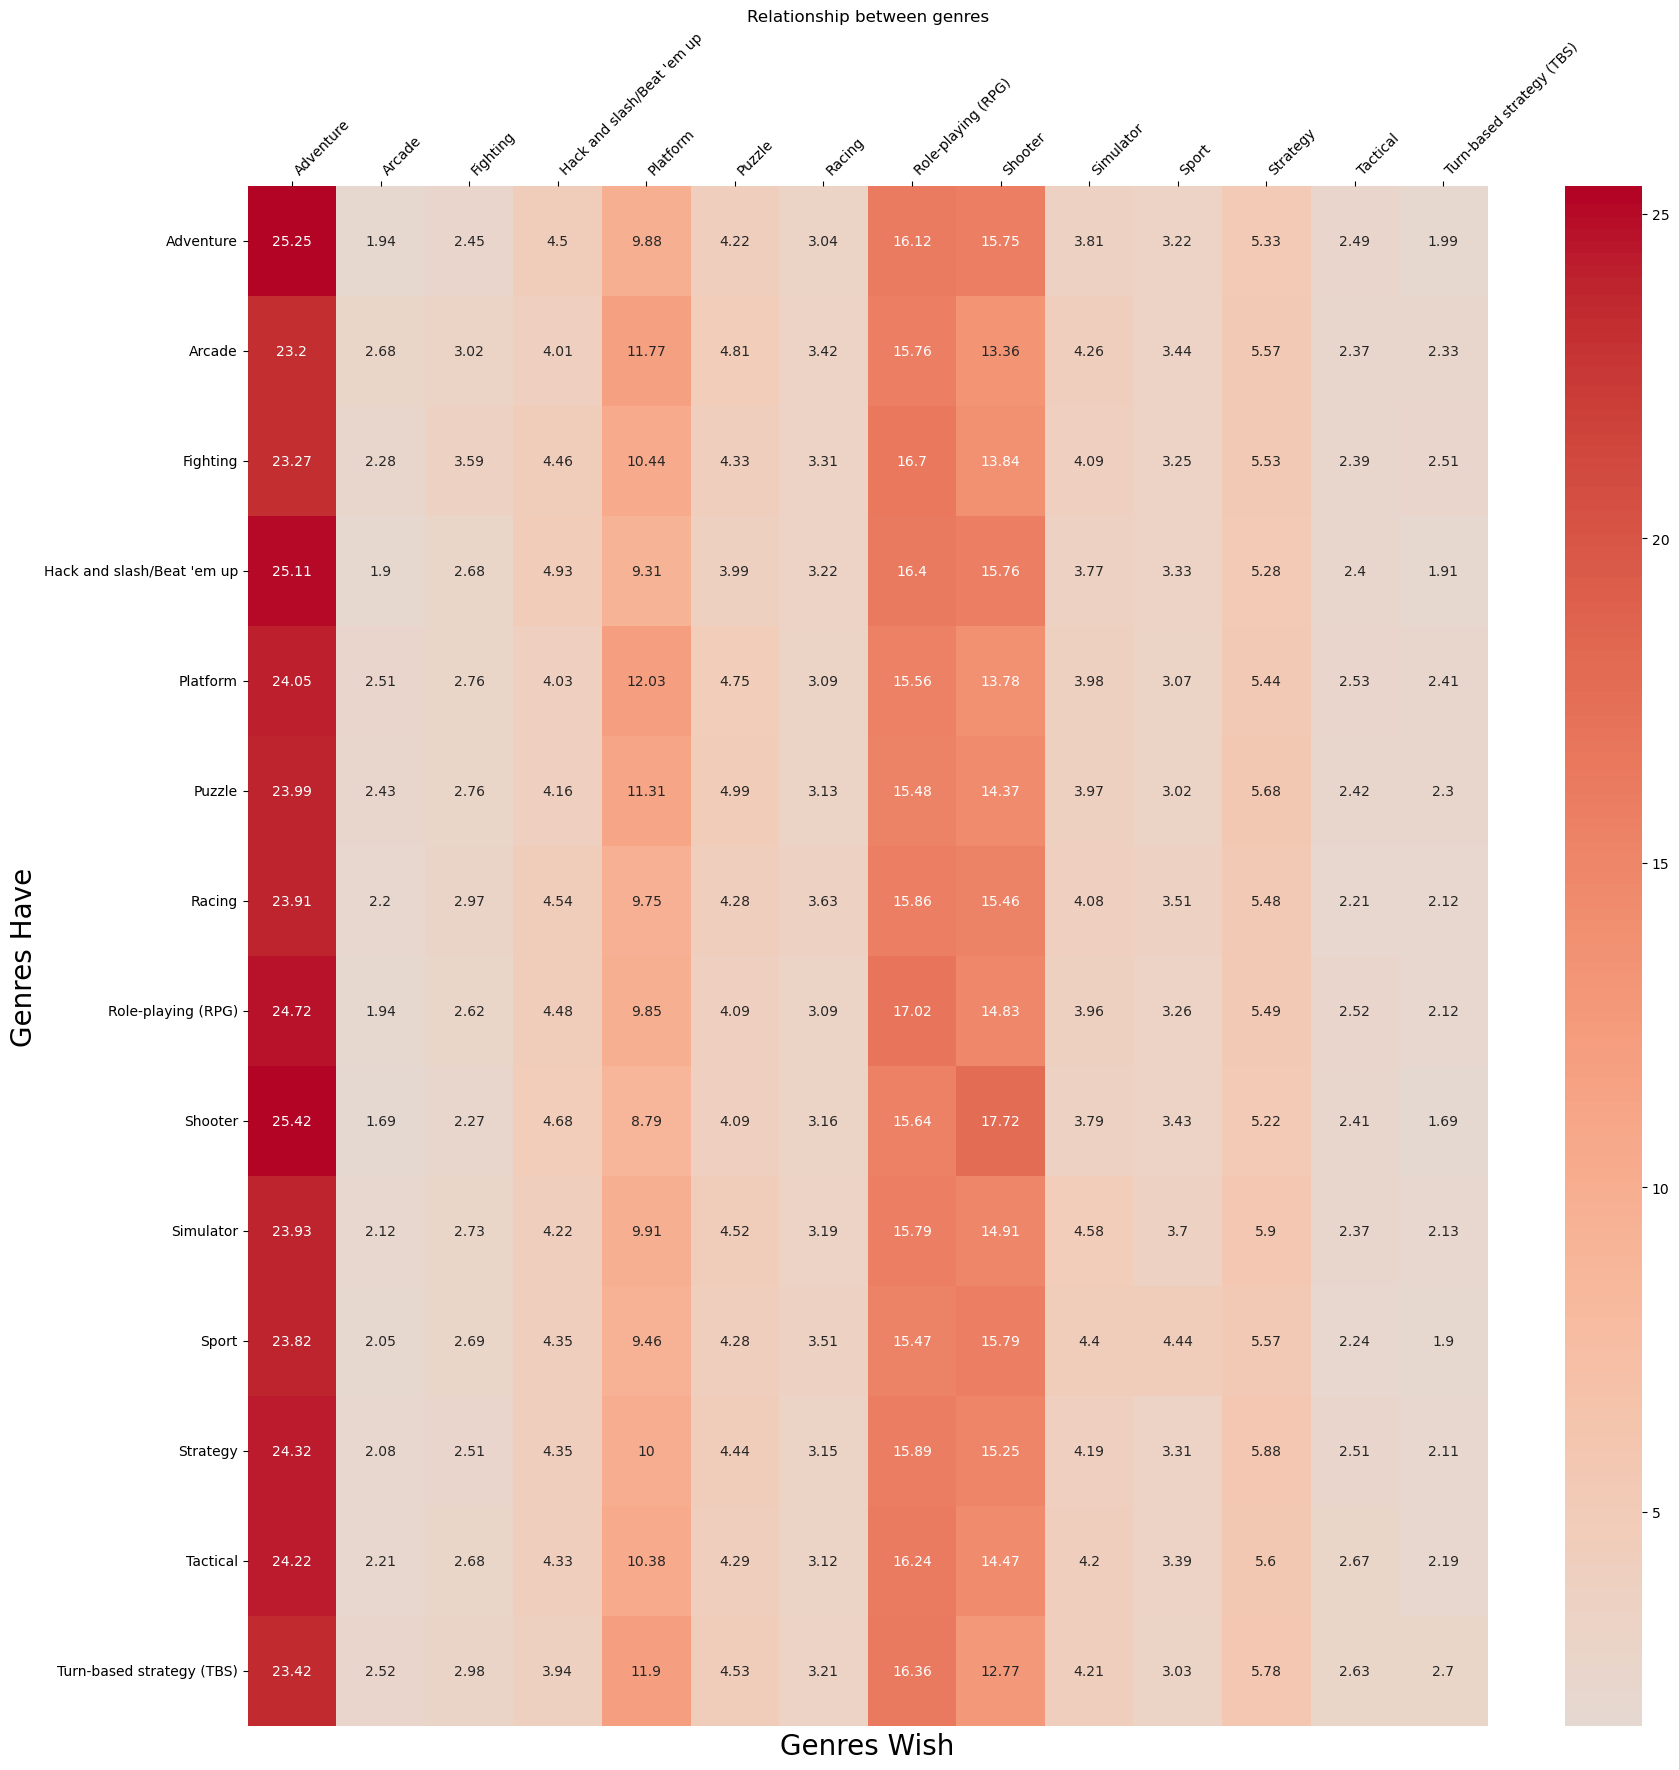

In [69]:
plot_relationship((relationship_have_wish_norm).round(2), 'have_wish_norm_filtered', genres_names=genres_names, have_wish=True,processed=True)

In [70]:
# plot_relationship(relationship_diff_plot, 'diff', genres_names=games_genres, processed=True, have_wish=True)

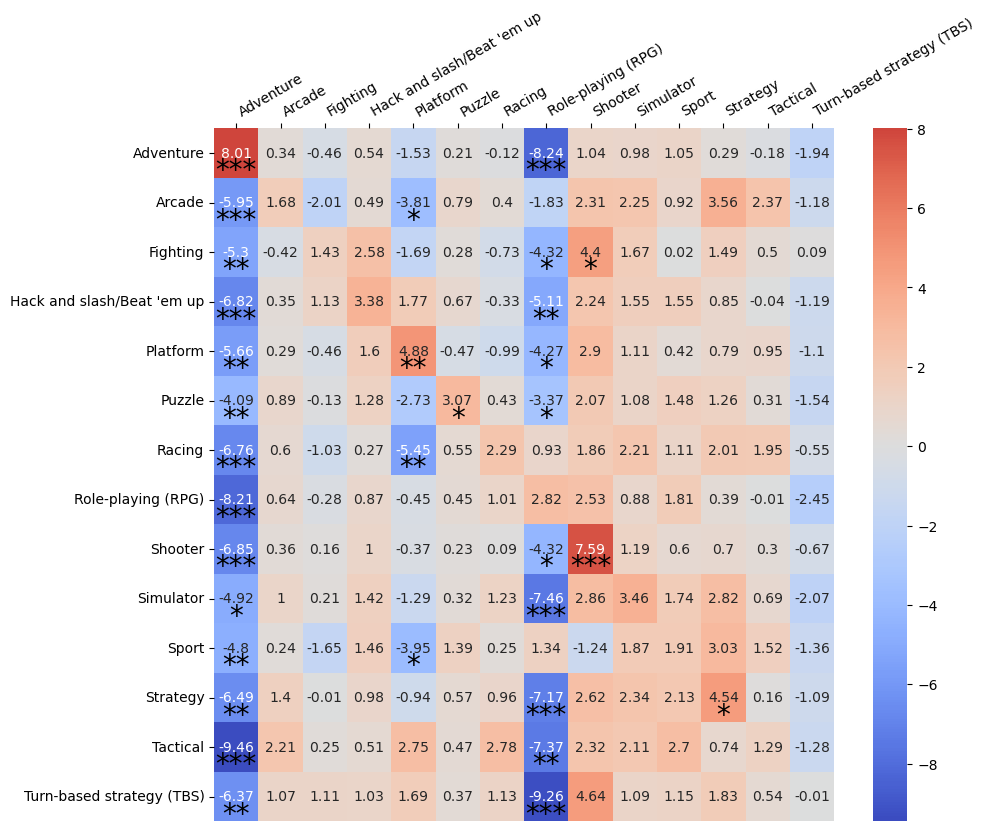

In [71]:
plot_relationship_with_t(relationship_diff_plot, 'diff_t', genres_names=games_genres,save=True)

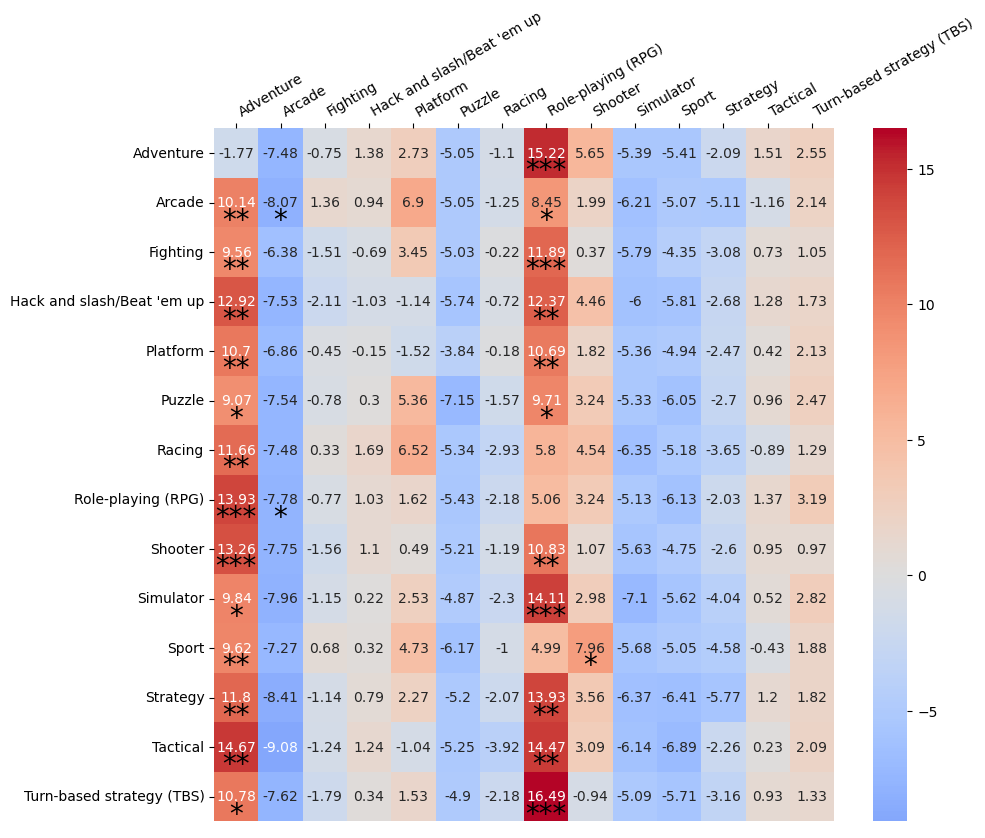

In [73]:
plot_relationship_with_t(relationship_confirmed_norm.apply(lambda x: x-df_console_genres_count['percent'].values, axis=1).round(2), 'confirmed_relationship_t_minus_base', genres_names=games_genres,save=True)

In [127]:
df_have_filtered = df_have.loc[df_have['name'].isin(confirmed_filtered.index)]
df_have_filtered['percent']=df_have_filtered['count']/df_have_filtered['count'].sum()*100
df_wish_filtered = df_wish.loc[df_wish['name'].isin(confirmed_filtered.index)]
df_wish_filtered['percent']=df_wish_filtered['count']/df_wish_filtered['count'].sum()*100

/tmp/ipykernel_19154/3718026834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_have_filtered['percent']=df_have_filtered['count']/df_have_filtered['count'].sum()*100
/tmp/ipykernel_19154/3718026834.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wish_filtered['percent']=df_wish_filtered['count']/df_wish_filtered['count'].sum()*100


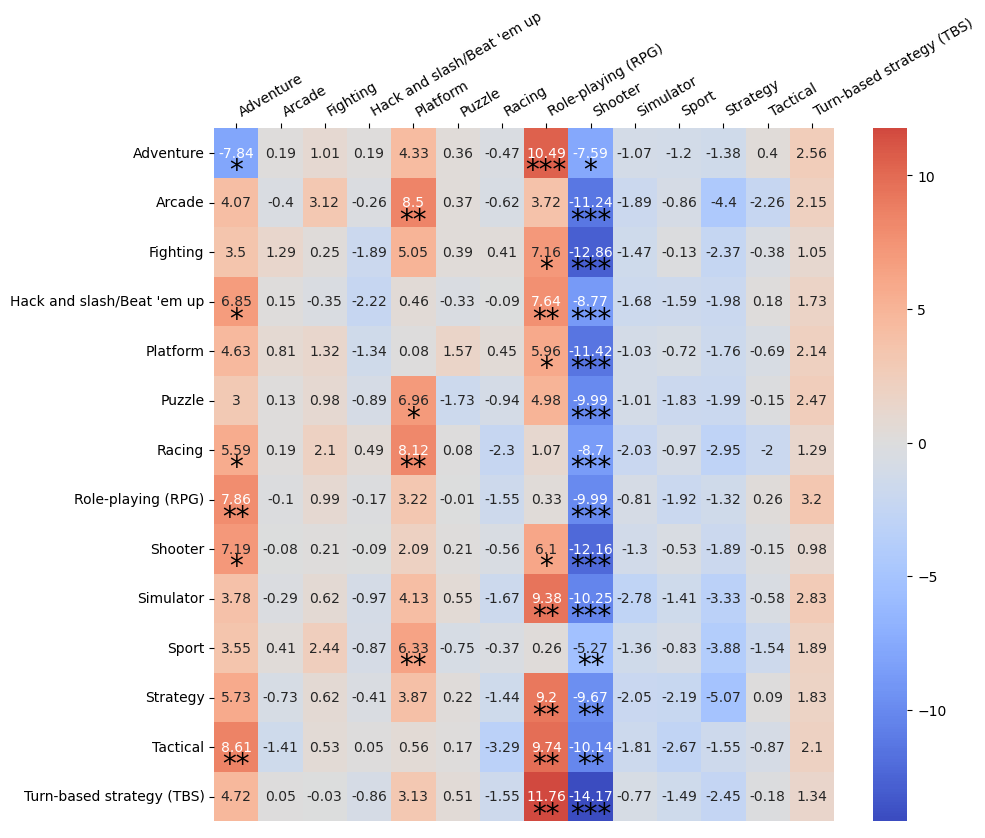

In [97]:
plot_relationship_with_t(relationship_confirmed_norm.apply(lambda x: x-df_have_filtered['percent'].values, axis=1).round(2), 'confirmed_relationship_t_minus_have', genres_names=games_genres,save=True)

In [105]:
print(df_have_filtered[['name','count','percent']].sort_values(by='percent', ascending=False).round(2).to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                      name &  count &  percent \\
\midrule
                 Adventure &   9650 &    25.08 \\
                   Shooter &   8581 &    22.30 \\
        Role-playing (RPG) &   5337 &    13.87 \\
                  Platform &   2723 &     7.08 \\
                  Strategy &   2468 &     6.41 \\
                 Simulator &   1500 &     3.90 \\
Hack and slash/Beat 'em up &   1452 &     3.77 \\
                    Puzzle &   1406 &     3.65 \\
                    Racing &   1398 &     3.63 \\
                     Sport &   1296 &     3.37 \\
                  Tactical &    871 &     2.26 \\
                  Fighting &    733 &     1.90 \\
                    Arcade &    541 &     1.41 \\
 Turn-based strategy (TBS) &    528 &     1.37 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_19154/3569170209.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_have_filtered[['name','count','percent']].sort_values(by='percent', ascending=False).round(2).to_latex(index=False))


In [120]:
confirmed_filtered.index

Index(['Adventure', 'Arcade', 'Fighting', 'Hack and slash/Beat 'em up',
       'Platform', 'Puzzle', 'Racing', 'Role-playing (RPG)', 'Shooter',
       'Simulator', 'Sport', 'Strategy', 'Tactical',
       'Turn-based strategy (TBS)'],
      dtype='object', name='name_1')

In [121]:
df_confirmed = confirmed.apply(lambda x: sum(x), axis=1).sort_values(ascending=False).to_frame()
df_confirmed_filtered = df_confirmed.loc[df_confirmed.index.isin(confirmed_filtered.index)]
df_confirmed_filtered.reset_index(inplace=True)
df_confirmed_filtered.columns = ['genres', 'count']
df_confirmed_filtered['percent'] = df_confirmed_filtered['count']/df_confirmed_filtered['count'].sum()*100

/tmp/ipykernel_19154/1807004956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_confirmed_filtered['percent'] = df_confirmed_filtered['count']/df_confirmed_filtered['count'].sum()*100


In [122]:
print(df_confirmed_filtered[['genres','count','percent']].round(2).to_latex(index=False))


\begin{tabular}{lrr}
\toprule
                    genres &  count &  percent \\
\midrule
                 Adventure & 3744.0 &    27.31 \\
        Role-playing (RPG) & 2777.0 &    20.26 \\
                   Shooter & 1694.0 &    12.36 \\
                  Platform & 1459.0 &    10.64 \\
                  Strategy &  613.0 &     4.47 \\
                    Puzzle &  536.0 &     3.91 \\
 Turn-based strategy (TBS) &  500.0 &     3.65 \\
Hack and slash/Beat 'em up &  463.0 &     3.38 \\
                  Fighting &  391.0 &     2.85 \\
                    Racing &  381.0 &     2.78 \\
                 Simulator &  370.0 &     2.70 \\
                  Tactical &  296.0 &     2.16 \\
                     Sport &  281.0 &     2.05 \\
                    Arcade &  205.0 &     1.50 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_19154/3529246509.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_confirmed_filtered[['genres','count','percent']].round(2).to_latex(index=False))


In [129]:
print(df_wish_filtered[['name','count','percent']].sort_values(by='percent', ascending=False).round(2).to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                      name &  count &  percent \\
\midrule
                 Adventure &  11265 &    26.62 \\
                   Shooter &   7969 &    18.83 \\
        Role-playing (RPG) &   6614 &    15.63 \\
                  Platform &   3255 &     7.69 \\
                  Strategy &   2536 &     5.99 \\
                 Simulator &   1768 &     4.18 \\
Hack and slash/Beat 'em up &   1764 &     4.17 \\
                    Puzzle &   1666 &     3.94 \\
                     Sport &   1359 &     3.21 \\
                    Racing &   1338 &     3.16 \\
                  Tactical &    895 &     2.12 \\
                  Fighting &    744 &     1.76 \\
 Turn-based strategy (TBS) &    599 &     1.42 \\
                    Arcade &    544 &     1.29 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_19154/1311321147.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_wish_filtered[['name','count','percent']].sort_values(by='percent', ascending=False).round(2).to_latex(index=False))
